<a href="https://colab.research.google.com/github/zClarkk/Medical-Deep-Learning-Collection/blob/main/ECG_Classification_ResNet_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: ECG Classification with ResNet and LSTM

The goal of this exercise is to classify (variable-length) ECG recordings of the PhysioNet/CinC Challenge into four rhythm classes:
+ normal sinus rhythms (N)
+ atrial fibrillation (AF)
+ other rhythms (O)
+ noise signals (∼).

Therefore, we will investigate into a fully convolutional approach as well as an approach using LSTM-cells and compare their results. The bonus task will deal with the classification using transformers.

In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=9b5a526f985d8055c4eb809226cb6e662f4ea33234eccdaa04f9f51dc943dac9
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 18.3 MB/s eta 0:00:00


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

import os
import wget
import zipfile
import csv
import scipy.io

# check if cuda and training with mixed precision is available
tensor_cores_available = False
if (torch.cuda.is_available() == False):
    print('CUDA not found! It is highly recommended to enable CUDA for the exercises')
else:
    print('CUDA GPU found: ', torch.cuda.get_device_name(['0']))
    if torch.cuda.get_device_capability('cuda')[0] >= 7:
        tensor_cores_available = True
        print('Turing/Ampere with TensorCores is available, you can speed up training with FP16 precision')

CUDA GPU found:  Tesla T4
Turing/Ampere with TensorCores is available, you can speed up training with FP16 precision


In [ ]:
# get physionet_dataset
! wget -nc 'https://archive.physionet.org/challenge/2017/REFERENCE-v3.csv'
def get_physionet_dataset():
    # settings
    sample_rate = 300
    dataset_path = './training2017'
    dataset_url = 'https://archive.physionet.org/challenge/2017/training2017.zip'
    dataset_annotations = 'REFERENCE-v3.csv'

    # download data (this may take ~1 minute)
    if not os.path.isfile(dataset_path + '.zip'):
        wget.download(dataset_url)
    if not os.path.isdir(dataset_path):
        zipfile.ZipFile(dataset_path + '.zip','r').extractall()

    # build dataset from reference file
    with open(dataset_annotations, 'r') as f:
        reader = csv.reader(f)
        dataset = []
        label_dict = {'N': torch.tensor([0]).long(), 'A': torch.tensor([1]).long(), 'O': torch.tensor([2]).long(), '~': torch.tensor([3]).long()}
        for file_name, label in reader:
            dataset.append({'input': torch.from_numpy(scipy.io.loadmat(os.path.join(dataset_path, file_name + '.mat'))['val']).float().squeeze(),
                            'target': label_dict[label]})

    return dataset, sample_rate

--2023-05-21 08:42:57--  https://archive.physionet.org/challenge/2017/REFERENCE-v3.csv
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76752 (75K) [text/plain]
Saving to: ‘REFERENCE-v3.csv’

REFERENCE-v3.csv    100%[===================>]  74.95K   170KB/s    in 0.4s    

2023-05-21 08:42:58 (170 KB/s) - ‘REFERENCE-v3.csv’ saved [76752/76752]



## Task 0: PhysioNet/CinC Challenge

Inspect the challenge data. In the following cell the physionet dataset is loaded and relevant dataset information is printed as well as exemplary ECG rhythms are plotted.

First we get the raw data and their corresponding labels as a list of dicts (keys: input, target). We extract the ground truth/labels and save them in the tensor `labels`. To keep the labels in a human-readable way, we also create a mapping `label_map`.

In [ ]:
records_and_labels, sample_rate = get_physionet_dataset()
labels = torch.tensor([e['target'] for e in records_and_labels])
label_map = ['N', 'AF', 'O', '~']

Next, we want to extract some basic information about our dataset like the number of data its holding as well as the class distribution.

number of recordings:  8528
number of classes: 4


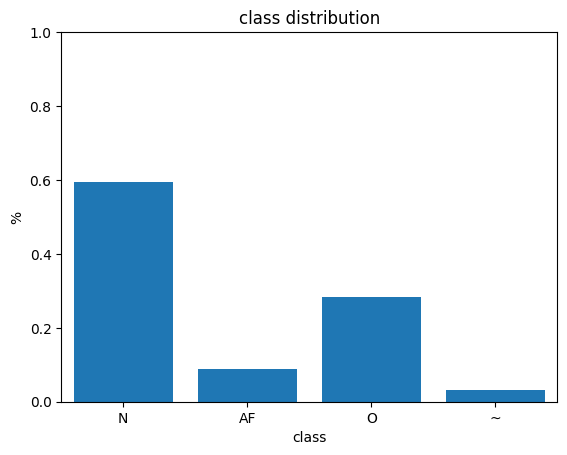

In [ ]:
# number of recordings
num_recordings = len(labels)
print('number of recordings: ', num_recordings)

# number of classes
num_classes = torch.unique(labels).numel()
print('number of classes:', num_classes)

# class distribution
class_distribution = torch.histc(labels.float(), bins=num_classes)/num_recordings
plt.figure('class distribution')
plt.bar(torch.arange(num_classes), class_distribution)
plt.title('class distribution')
plt.xlabel('class')
plt.xticks(ticks=torch.arange(num_classes), labels=label_map)
plt.xlim([-0.5, num_classes-0.5])
plt.ylabel('%')
plt.ylim([0, 1]);

Let's plot an example for every of our four ECG types.

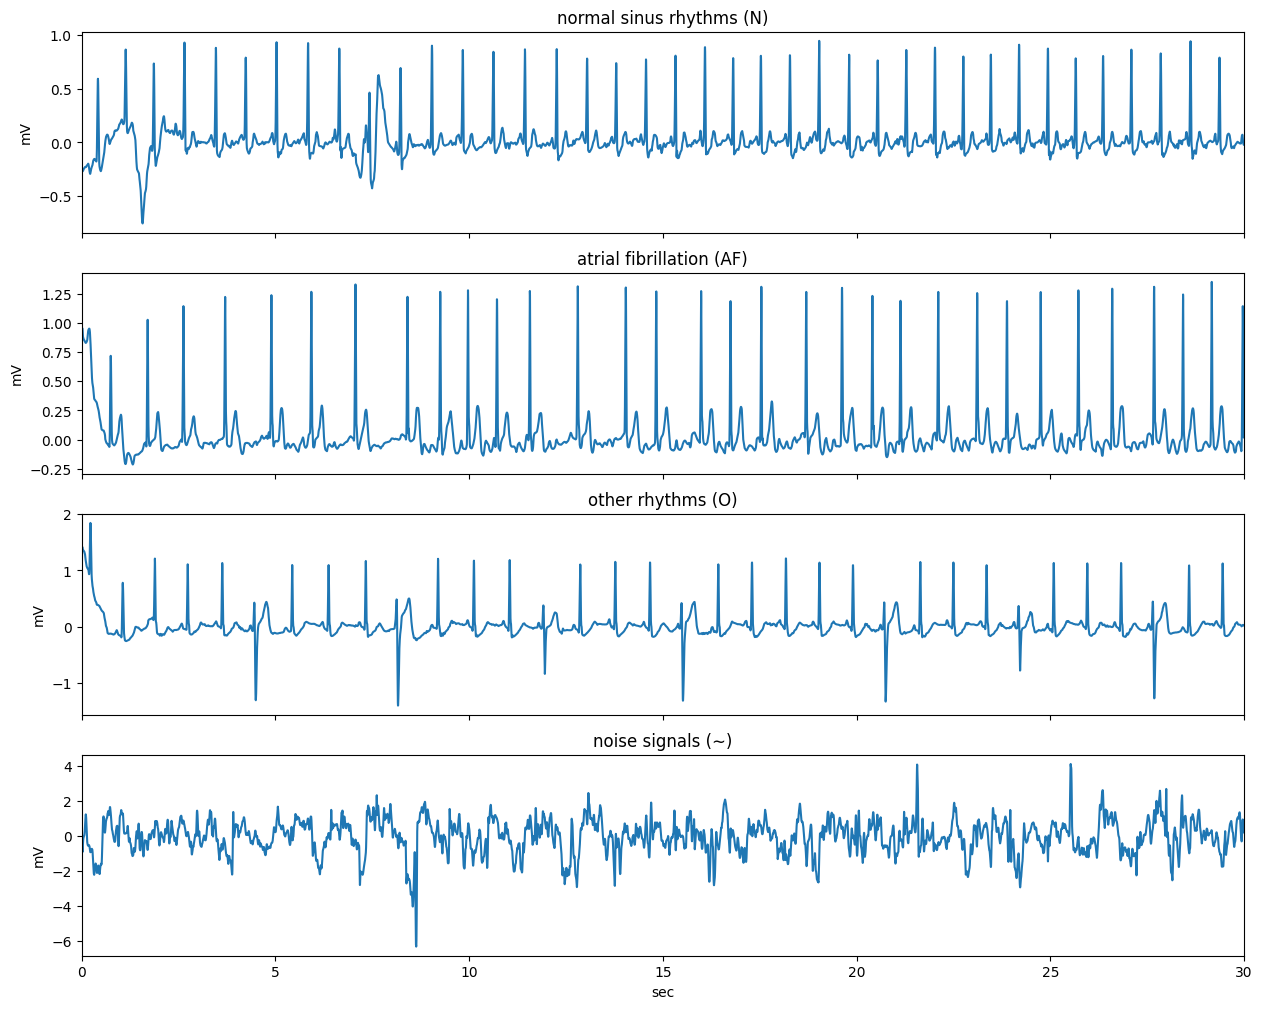

In [ ]:
# plot signals (one example for each target)
fig, axs = plt.subplots(num_classes, 1, sharex=True, figsize=(15,3*num_classes))
index = [0, 3, 76, 1245]
long_label_mapping = ['normal sinus rhythms (N)', 'atrial fibrillation (AF)', 'other rhythms (O)', 'noise signals (∼)']

for i in range(num_classes):
    signal = records_and_labels[index[i]]['input']
    axs[i].plot((torch.arange(signal.numel()).float()/sample_rate).numpy(), (signal/1000).numpy())
    axs[i].set_title(long_label_mapping[i])
    axs[i].set_xlim([0, 30])
    axs[i].set_ylabel('mV')
axs[i].set_xlabel('sec');

The last information, we want to extract, is the distribution of the signal length.

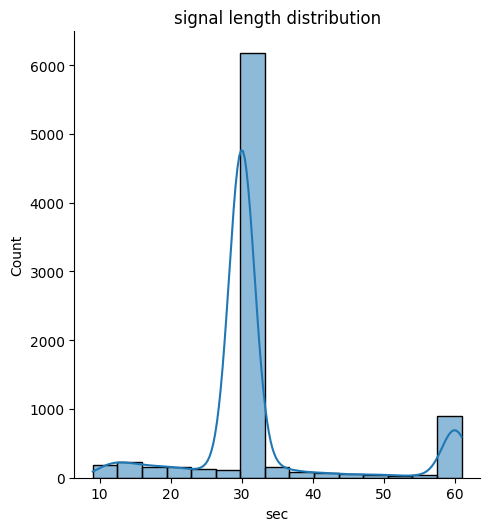

In [ ]:
import seaborn as sns

sns.displot([entry['input'].numel()/sample_rate for entry in records_and_labels], kde=True)
plt.title('signal length distribution')
plt.xlabel('sec');

## Task 1 (20 points): Preprocessing

As you saw in the previous cell, the recordings in the dataset are not normalized and of variable sequence length.

To use the ecg signals with our neural nets normalize each recording $s$ to have *zero mean* and *unit variance*.
$$
s'=\frac{s-\mu_s}{\sigma_s}
$$
where $\mu_s$ and $\sigma_s$ are the mean and standard deviation calculated over each record in the dataset. Iterate over the dataset to calculate $\mu$ and $\sigma$ for each record and normalize it.

In [ ]:
# normalize each recording
for i in range(num_recordings):
    # load
    signal = records_and_labels[i]['input']

    signal = (signal-signal.mean())/signal.std()

    # save
    records_and_labels[i]['input'] = signal

To make the handling of the data easier, we want to ensure, that all signals have the **same length of 30 seconds**. To do that, iterate over the data:
* if a recording is longer than 30 seconds crop it symmetrically
* if it is shorter pad the signal with zeros using `F.pad` ([pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html)), again symmetrically.

To obtain the length of the signal in seconds, divide its length/number of elements with the `sample_rate` in Hz (it is the same for all recordings). The cropped or padded signal should then append to the list `data`.

In [ ]:
# to fixed signal length
x = set()
fixed_signal_length = 30
for i in range(num_recordings):
    # load
    signal = records_and_labels[i]['input']

    signal_length = signal.numel() / sample_rate
    if signal_length < fixed_signal_length:
        needed_padding = (fixed_signal_length*sample_rate-signal.numel())//2
        needed_padding1 = needed_padding
        if needed_padding1+needed_padding+signal.numel()!=fixed_signal_length*sample_rate:
          needed_padding1=fixed_signal_length*sample_rate-needed_padding-signal.numel()
        signal = F.pad(signal,(needed_padding,needed_padding1))

    elif signal_length > fixed_signal_length:
        middle=int(signal_length*150)
        signal = signal[int(middle-15*sample_rate):int(middle+15*sample_rate)]

    # save
    x.add(signal.numel() / sample_rate)
    records_and_labels[i]['input'] = signal
print(x)

{30.0}


As you can remember from the class distribution plot, the classes $\omega$ are unbalanced. So we create class weights $w_\omega$ to weight the loss during training. We obtain them with the formula of the **root inverse frequency**:
$$ w_{\omega_i} = \sqrt{(P_{\omega_i})^{-1}}$$
We calculate $P_{\omega_i}$ by counting the labels with `torch.bincount` and dividing them by `num_recordings`. The first element of the weight tensor should contain $1.2995$.

In [ ]:
#TODO
P = torch.bincount(labels.flatten())/num_recordings
print(P)
class_weights = (P**-1)**0.5
print(class_weights)

tensor([0.5952, 0.0889, 0.2832, 0.0327])
tensor([1.2962, 3.3542, 1.8792, 5.5287])


Next, we prepare all data in datasets for training and validation. In this exercise we perform a single fold validation on a fixed train/valid set (with ratio 90:10).

In [ ]:
# provided dataset class
class CinCDataset(Dataset):
    def __init__(self, data: torch.Tensor, ground_truth: torch.Tensor):
        super().__init__()
        self.data = data.unsqueeze(1)
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.ground_truth[idx]

# for reproducibility (do not change)
torch.manual_seed(0)

# split dataset in train/valid set
ratio = 0.9
split = int(num_recordings*ratio)
perm = torch.randperm(num_recordings)

dataset_train = [records_and_labels[i] for i in perm[:split]]
dataset_valid = [records_and_labels[i] for i in perm[split:]]

input_train = torch.stack([entry['input'] for entry in dataset_train])
target_train = torch.cat([entry['target'] for entry in dataset_train])
input_valid = torch.stack([entry['input'] for entry in dataset_valid])
target_valid = torch.cat([entry['target'] for entry in dataset_valid])

# create dataloader for training
train_dataset = CinCDataset(input_train, target_train)
val_dataset = CinCDataset(input_valid, target_valid)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, drop_last=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Task 2: Implementing and training the convolutional backbone
### Task 2.1 (15 points): ResNetBlock
We want to use the famous ResNet architecture for our CNNs. Therefore, we need to implement the `ResNetBlock` as a module to make the building of our ResNets easier and more flexible. For the implementation follow the illustration using the appropriate torch functions and substitute the ReLUs with leaky ones for a further improvement .
![res block](https://drive.google.com/uc?export=view&id=1aj13ywlRJp4h0lIeLVyrtSuprZbV7LWJ)

In [ ]:
 class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=17):
        super(ResNetBlock, self).__init__()
        self.left_block = nn.Sequential(nn.Conv1d(in_channels,out_channels,1,stride=2,bias=False),
                                        nn.BatchNorm1d(out_channels))
        self.right_block = nn.Sequential(nn.Conv1d(in_channels,out_channels,kernel_size=kernel_size,stride=2,padding=kernel_size//2,bias=False),
                                         nn.BatchNorm1d(out_channels),
                                         nn.ReLU(),
                                         nn.Conv1d(out_channels,out_channels,kernel_size=kernel_size,padding=kernel_size//2,bias=False),
                                         nn.BatchNorm1d(out_channels)
                                         )
        self.relu=nn.ReLU()

    def forward(self, x):

        x_left = self.left_block(x)
        x_right = self.right_block(x)
        x = self.relu(x_left + x_right)

        return x

### Task 2.2 (15 points): Small ResNet as convolutional backbone
The goal of this exercise is to compare the performance of convolutions and LSTM-cells for the classification of time series. To allow a shorter training of each method, we first build a convolutional backbone that will function as a feature extractor as a starting point for each of the two methods.

The `ResBackbone` consist of:
- single sequential block `input_conv`: 1d-convolution with output channels = 16, kernel size = 17, same padding and stride = 1 (remember to disable the bias in the convolution layer), 1d-batch normalization  and leaky ReLU activation.
- three `ResNetBlock`s that you implemented above: the first and the third `ResNetBlock`s double the number of channels, so that output of `ResBackbone` should have 64 channels.

In [ ]:
class ResBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_conv = nn.Sequential(
            nn.Conv1d(1,16,17,padding=8,bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        self.backbone = nn.Sequential(
            ResNetBlock(16,32),
            ResNetBlock(32,32),
            ResNetBlock(32,64)
        )

    def forward(self, x):

        x=self.input_conv(x)
        x=self.backbone(x)

        return x

In [ ]:
summary(ResBackbone(), (1, 1, 30*sample_rate))

Layer (type:depth-idx)                   Output Shape              Param #
ResBackbone                              [1, 64, 1125]             --
├─Sequential: 1-1                        [1, 16, 9000]             --
│    └─Conv1d: 2-1                       [1, 16, 9000]             272
│    └─BatchNorm1d: 2-2                  [1, 16, 9000]             32
│    └─ReLU: 2-3                         [1, 16, 9000]             --
├─Sequential: 1-2                        [1, 64, 1125]             --
│    └─ResNetBlock: 2-4                  [1, 32, 4500]             --
│    │    └─Sequential: 3-1              [1, 32, 4500]             576
│    │    └─Sequential: 3-2              [1, 32, 4500]             26,240
│    │    └─ReLU: 3-3                    [1, 32, 4500]             --
│    └─ResNetBlock: 2-5                  [1, 32, 2250]             --
│    │    └─Sequential: 3-4              [1, 32, 2250]             1,088
│    │    └─Sequential: 3-5              [1, 32, 2250]             34,944
│ 

Check your backbone with the `summary` function, it should consists of $170\,032$ trainable parameters and return an output size of $[B=1, 64, 1125]$.

Next, we want to train the backbone. It's performance can be considered as a baseline.
Implement `ResBaseline` module by addition of classifier head to the `ResBackbone`. Classifier head will contain:
- adaptive average pulling `nn.AdaptiveAvgPool1d()` to reduce the temporal dimension to 1.
- fully-connected layer `nn.Linear()` with 4 outputs (4 ECG classes).

In [ ]:
class ResBaseline(nn.Module):
    def __init__(self):
        super(ResBaseline, self).__init__()

        self.backbone = ResBackbone()

        #TODO
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(64,4)

    def forward(self, x):
        x=self.backbone(x)
        x=self.pool(x)
        x=self.classifier(x.flatten(start_dim=1))

        return x

In [ ]:
summary(ResBaseline(), (1, 1, 30*sample_rate))

Layer (type:depth-idx)                        Output Shape              Param #
ResBaseline                                   [1, 4]                    --
├─ResBackbone: 1-1                            [1, 64, 1125]             --
│    └─Sequential: 2-1                        [1, 16, 9000]             --
│    │    └─Conv1d: 3-1                       [1, 16, 9000]             272
│    │    └─BatchNorm1d: 3-2                  [1, 16, 9000]             32
│    │    └─ReLU: 3-3                         [1, 16, 9000]             --
│    └─Sequential: 2-2                        [1, 64, 1125]             --
│    │    └─ResNetBlock: 3-4                  [1, 32, 4500]             26,816
│    │    └─ResNetBlock: 3-5                  [1, 32, 2250]             36,032
│    │    └─ResNetBlock: 3-6                  [1, 64, 1125]             106,880
├─AdaptiveAvgPool1d: 1-2                      [1, 64, 1]                --
├─Linear: 1-3                                 [1, 4]                    260
Total

### Task 2.3 (25 points): Training routine
Complete the training routine function `train` below. For the training use:
- Adam optimizer with an initial learning rate of __0.001__.
- exponential decay of the learning rate with a factor = __0.95__.
- cross-entropy loss with root-inverse class weighting to encounter for the class-imbalance.

Useful PyTorch functions: `optim.Adam(), optim.lr_scheduler.ExponentialLR(), nn.CrossEntropyLoss()`

In [ ]:
from torch.cuda import amp
import torchmetrics as metric

def train(model, num_epochs, lr_decay=0.95, lr=0.001):

    #TODO
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #TODO
    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

    #TODO
    # criterion
    criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

    # for reproducibility (do not change)
    torch.manual_seed(0)

    # statistics
    ce_mean = metric.MeanMetric().cuda()
    f1_metric = metric.classification.MulticlassF1Score(num_classes).cuda()
    best_val_f1 = []

    # for num_epochs
    for epoch in trange(num_epochs, unit='epoch'):

        # train mode
        model.train()

        # statistics
        ce_mean.reset()
        f1_metric.reset()

        # for each mini-batch
        for input, target in train_dataloader:
            target=target.cuda()
            #TODO
            output = model(input.cuda())
            loss = criterion(output,target.cuda())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # statistics
            ce_mean(loss)
            f1_metric(output, target.cuda())


        # update learning rate
        lr_scheduler.step()

        # output
        tqdm.write('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}'.format(epoch, ce_mean.compute(), f1_metric.compute()))

        # validate

        # eval mode
        model.eval()

        # statistics
        ce_mean.reset()
        f1_metric.reset()

        # for each mini-batch
        for input, target in val_dataloader:
            target = target.cuda()
            #TODO
            output = model(input.cuda())
            loss = criterion(output,target.cuda())

            # statistics
            ce_mean(loss)
            f1_metric(output, target.cuda())

        # output
        tqdm.write('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}\n'.format(epoch, ce_mean.compute(), f1_metric.compute()))
        # statistics
        best_val_f1.append(f1_metric.compute().item())
        ce_mean.reset()
        f1_metric.reset()

    # make model callable outside this function
    train.trained_model = model

    # best F1 score
    print('Best F1 score (valid):', '{:.2f}'.format(round(max(best_val_f1), 2)))

Call the training function to train your `ResBaseline` for __10__ epochs.
After training the best validation F1 score should be around 0.68.

In [ ]:
baseline = ResBaseline().cuda()
train(baseline, 10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 (train) -- loss: 0.9900 f1: 0.4600
Epoch 0 (valid) -- loss: 0.8175 f1: 0.5729

Epoch 1 (train) -- loss: 0.8244 f1: 0.5735
Epoch 1 (valid) -- loss: 0.7664 f1: 0.5672

Epoch 2 (train) -- loss: 0.7720 f1: 0.5984
Epoch 2 (valid) -- loss: 0.7322 f1: 0.6103

Epoch 3 (train) -- loss: 0.7421 f1: 0.6132
Epoch 3 (valid) -- loss: 0.7153 f1: 0.6393

Epoch 4 (train) -- loss: 0.7181 f1: 0.6342
Epoch 4 (valid) -- loss: 0.7000 f1: 0.6593

Epoch 5 (train) -- loss: 0.7108 f1: 0.6329
Epoch 5 (valid) -- loss: 0.7223 f1: 0.6508

Epoch 6 (train) -- loss: 0.6879 f1: 0.6531
Epoch 6 (valid) -- loss: 0.6654 f1: 0.6604

Epoch 7 (train) -- loss: 0.6763 f1: 0.6548
Epoch 7 (valid) -- loss: 0.6736 f1: 0.6329

Epoch 8 (train) -- loss: 0.6633 f1: 0.6652
Epoch 8 (valid) -- loss: 0.6340 f1: 0.6984

Epoch 9 (train) -- loss: 0.6480 f1: 0.6764
Epoch 9 (valid) -- loss: 0.6612 f1: 0.6702

Best F1 score (valid): 0.70


## Task 3: Compare convolutions and LSTM-cells
Finally, we want to start our little experiment to compare the performance of a plain convolutional classifier and a classifier that based on LSTM features.
We will use the pretrained backbone from the previous task as an encoder. Following function `extract_pretrained_backbone` returns the pretrained backbone of the `ResBaseline` model.

In [ ]:
def extract_pretrained_backbone(model: ResBaseline):
    return deepcopy(model.backbone)

Extract the pretrained backbone from baseline model.

In [ ]:
conv_backbone = extract_pretrained_backbone(baseline)

In order to train both models convolution-based and LSTM-based we will use `Classifier` module that is implemented bellow.
`Classifier` contains pretrained backbone, sequence processor `seq` (can be either convolution-based or LSTM-based), and a single fully-connected layer.
Class method `check_compatibility` will help to ensure that sequence processor returns output with right dimensions.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, pretrainend_backbone:ResBackbone, sequence_processor:nn.Module, num_classes=4):
        super().__init__()
        self.backbone = pretrainend_backbone
        self.seq = sequence_processor
        self.classifier = nn.Linear(64, num_classes, bias=True)

    def forward(self, x):
        x = self.backbone(x)
        x = self.seq(x)
        x = self.classifier(x)

        return x

    @classmethod
    def check_compatibility(cls, sequence_processor: nn.Module):
        batch_size = 2
        features_from_backbone = torch.rand(batch_size, 64, 1125) # BxCxW
        out = sequence_processor(features_from_backbone)
        target_shape = torch.Size([batch_size, 64])

        if out.shape != target_shape:
            raise AssertionError(f'Expected input {features_from_backbone.shape} to be processed to shape {target_shape}, but found shape {out.shape}')
        else:
            print('CHECK COMPLETED')

### Task 3.1 (10 points): Convolutional approach
First we will check performance of the convolution approach.
Implement convolution sequence processor `conv_approach` that consists of:
- two `ResNetBlock`s: first expands channel dimension to 128 and second reduce it back to 64.
- adaptive average pulling `nn.AdaptiveAvgPool1d()` to reduce the temporal dimension (use `nn.Flatten` after the pooling layer to get rid of temporal dimension and pass compatability check).

In [ ]:
conv_approach = nn.Sequential(
  ResNetBlock(64,128),
  ResNetBlock(128,64),
  nn.AdaptiveAvgPool1d(1),
  nn.Flatten()
)

Call `check_compatibility` function to make sure that sequence processor returns output with right dimensions.

In [ ]:
Classifier.check_compatibility(conv_approach)

CHECK COMPLETED


Instantiate `Classifier` model with pretrained backbone and convolutional sequence processor and check number of parameters.
Total parameter count should be __814,516__.

In [ ]:
conv_classifier = Classifier(conv_backbone, conv_approach).cuda()
summary(conv_classifier, (1, 1, 30*sample_rate))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Output Shape              Param #
Classifier                                    [1, 4]                    --
├─ResBackbone: 1-1                            [1, 64, 1125]             --
│    └─Sequential: 2-1                        [1, 16, 9000]             --
│    │    └─Conv1d: 3-1                       [1, 16, 9000]             272
│    │    └─BatchNorm1d: 3-2                  [1, 16, 9000]             32
│    │    └─ReLU: 3-3                         [1, 16, 9000]             --
│    └─Sequential: 2-2                        [1, 64, 1125]             --
│    │    └─ResNetBlock: 3-4                  [1, 32, 4500]             26,816
│    │    └─ResNetBlock: 3-5                  [1, 32, 2250]             36,032
│    │    └─ResNetBlock: 3-6                  [1, 64, 1125]             106,880
├─Sequential: 1-2                             [1, 64]                   --
│    └─ResNetBlock: 2-3                       [1, 128, 563]             --
│    │

Call the training function to train your convolution-based `Classifier` for __15__ epochs.
After training the best validation F1 score should be around 0.82.

In [ ]:
train(conv_classifier, 15)

  0%|          | 0/15 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 0.7250 f1: 0.6250
Epoch 0 (valid) -- loss: 0.7248 f1: 0.6201

Epoch 1 (train) -- loss: 0.6413 f1: 0.6809
Epoch 1 (valid) -- loss: 0.5789 f1: 0.6829

Epoch 2 (train) -- loss: 0.5920 f1: 0.7029
Epoch 2 (valid) -- loss: 0.5446 f1: 0.7120

Epoch 3 (train) -- loss: 0.5531 f1: 0.7251
Epoch 3 (valid) -- loss: 0.5089 f1: 0.7577

Epoch 4 (train) -- loss: 0.5284 f1: 0.7350
Epoch 4 (valid) -- loss: 0.5485 f1: 0.7473

Epoch 5 (train) -- loss: 0.5123 f1: 0.7435
Epoch 5 (valid) -- loss: 0.5096 f1: 0.7671

Epoch 6 (train) -- loss: 0.4799 f1: 0.7631
Epoch 6 (valid) -- loss: 0.4572 f1: 0.7745

Epoch 7 (train) -- loss: 0.4656 f1: 0.7760
Epoch 7 (valid) -- loss: 0.4765 f1: 0.7577

Epoch 8 (train) -- loss: 0.4453 f1: 0.7805
Epoch 8 (valid) -- loss: 0.4894 f1: 0.7624

Epoch 9 (train) -- loss: 0.4388 f1: 0.7882
Epoch 9 (valid) -- loss: 0.4581 f1: 0.7877

Epoch 10 (train) -- loss: 0.4270 f1: 0.7927
Epoch 10 (valid) -- loss: 0.4499 f1: 0.7844

Epoch 11 (train) -- loss: 0.4114 f1: 0.80

###  Task 3.1 (15 points): LSTM

![lstm_img](https://drive.google.com/uc?export=view&id=1u5wPANKBODEM9deW17eoXc69EA6aEEef)
Now it's time to measure performance of the LSTM approach.
Implement LSTM module that consists of:
- one additional `ResNetBlock` (`conv_feature`) that increases the channel dimension from 64 to 128.
- LSTM block `lstm_cells`: use `nn.LSTM` with output channels = __64__, number of layers = __4__ and batch_first = __True__.

__Pay attention__:
- LSTM module expects the input to be of shape __[B, L, C]__ while __B__ is a batch size, __L__ is a temporal dimension, and __C__ is a channel dimension. Output of `conv_feature` has the  __[B, C, L]__ structure. Then you should to transpose the output of `conv_feature` in the `forward` function using `torch.transpose` before providing it as an input to LSTM module.
- output of the LSTM module contains the hidden state to every sequence entry, but we are only interested in the __last one__. Use indexing to select it and `squeeze`method to get the output shape = __[B, 64]__.

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()

        #TODO
        self.conv_feature = ResNetBlock(64,128)
        self.lstm_cells = nn.LSTM(128,64,num_layers=4,batch_first=True)

    def forward(self, x):

        x = self.conv_feature(x)
        x= torch.transpose(x,1,2)
        x = self.lstm_cells(x)[-1][-1][-1]
        return x

Call `check_compatibility` function to make sure that sequence processor returns output with right dimensions.
Instantiate `Classifier` model with pretrained backbone and LSTM sequence processor and check number of parameters.
Total parameter count should be __746,548__.

In [ ]:
Classifier.check_compatibility(LSTMNet())
lstm_classifier = Classifier(extract_pretrained_backbone(baseline), LSTMNet())
summary(lstm_classifier, (1, 1, 30*sample_rate))

CHECK COMPLETED


Layer (type:depth-idx)                        Output Shape              Param #
Classifier                                    [1, 4]                    --
├─ResBackbone: 1-1                            [1, 64, 1125]             --
│    └─Sequential: 2-1                        [1, 16, 9000]             --
│    │    └─Conv1d: 3-1                       [1, 16, 9000]             272
│    │    └─BatchNorm1d: 3-2                  [1, 16, 9000]             32
│    │    └─ReLU: 3-3                         [1, 16, 9000]             --
│    └─Sequential: 2-2                        [1, 64, 1125]             --
│    │    └─ResNetBlock: 3-4                  [1, 32, 4500]             26,816
│    │    └─ResNetBlock: 3-5                  [1, 32, 2250]             36,032
│    │    └─ResNetBlock: 3-6                  [1, 64, 1125]             106,880
├─LSTMNet: 1-2                                [1, 64]                   --
│    └─ResNetBlock: 2-3                       [1, 128, 563]             --
│    │

Call the training function to train your LSTM-based `Classifier` for __15__ epochs.
After training the best validation F1 score should be around 0.67.

In [ ]:
train(lstm_classifier, 15)

  0%|          | 0/15 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 (train) -- loss: 1.0171 f1: 0.4067
Epoch 0 (valid) -- loss: 0.8901 f1: 0.5137

Epoch 1 (train) -- loss: 0.9538 f1: 0.4544
Epoch 1 (valid) -- loss: 0.9171 f1: 0.4486

Epoch 2 (train) -- loss: 0.8926 f1: 0.4828
Epoch 2 (valid) -- loss: 0.9781 f1: 0.3407

Epoch 3 (train) -- loss: 0.8911 f1: 0.4904
Epoch 3 (valid) -- loss: 0.8448 f1: 0.5535

Epoch 4 (train) -- loss: 0.9020 f1: 0.5175
Epoch 4 (valid) -- loss: 0.8243 f1: 0.5536

Epoch 5 (train) -- loss: 0.8741 f1: 0.5133
Epoch 5 (valid) -- loss: 0.8265 f1: 0.5531

Epoch 6 (train) -- loss: 0.8266 f1: 0.5375
Epoch 6 (valid) -- loss: 0.7301 f1: 0.6231

Epoch 7 (train) -- loss: 0.7964 f1: 0.5735
Epoch 7 (valid) -- loss: 0.7572 f1: 0.6073

Epoch 8 (train) -- loss: 0.7464 f1: 0.6081
Epoch 8 (valid) -- loss: 0.6926 f1: 0.6361

Epoch 9 (train) -- loss: 0.7086 f1: 0.6331
Epoch 9 (valid) -- loss: 0.7788 f1: 0.6165

Epoch 10 (train) -- loss: 0.6877 f1: 0.6526
Epoch 10 (valid) -- loss: 0.6847 f1: 0.6433

Epoch 11 (train) -- loss: 0.6831 f1: 0.65

## Bonus task: Transformer

Another newer approach is the use of so-called transformer, that relay on self-attention mechanism (see [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf))for the feature extraction instead of deep convolutional feature extractor.

Implement `TransformerClassifier` that consists of:
- very lightweight convolutional backbone here with two CBR-Blocks (`nn.Conv1d`, `nn.Batchnorm1d`, `nn.LeakyReLU`). Both have `kernel_size=17` and `stride=12`. The first block increase the channel_dimension to 32 and the second one double it to 64.
- `nn.TransformerEncoder` with `num_layers = 6`. As a layer `nn.TransformerEncoder` will use `nn.TransformerEncoderLayer` with `nhead=4, dim_feedforward=512`, `batch_first=True` and `d_model` = number of features extracted by a lightweight convolutional backbone.
- fully-connected layer as a classifier.

`forward` function should be implemented in similar manner to the LSTM-task, but instead of using the last entry of the `nn.TransformerEncoder` output as an input to the linear classifier, calculate the mean over its sequence dimension __L__.

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm1d
class TransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_backbone = nn.Sequential(
            nn.Conv1d(1,32,17,stride=12,bias=False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Conv1d(32,64,17,stride=12,bias=False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        #TODO
        self.transformer = nn.Sequential(
            nn.TransformerEncoder(nn.TransformerEncoderLayer(64,nhead=4,dim_feedforward=512,batch_first=True),num_layers=6)
        )
        self.classifier = nn.Linear(64,4)

    def forward(self, x):

        x = self.conv_backbone(x)
        x= torch.transpose(x,1,2)
        x = self.transformer(x)
        x = x.mean(1) # It is not 100% clear from the task description if the mean of x should be taken before the classifier or after, but this makes more sense (although both ways lead to the same result)
        x = self.classifier(x)


        return x

In [ ]:
transformer = TransformerClassifier()
summary(transformer, (1, 1, 30*sample_rate))

Layer (type:depth-idx)                             Output Shape              Param #
TransformerClassifier                              [1, 4]                    --
├─Sequential: 1-1                                  [1, 64, 62]               --
│    └─Conv1d: 2-1                                 [1, 32, 749]              544
│    └─BatchNorm1d: 2-2                            [1, 32, 749]              64
│    └─LeakyReLU: 2-3                              [1, 32, 749]              --
│    └─Conv1d: 2-4                                 [1, 64, 62]               34,816
│    └─BatchNorm1d: 2-5                            [1, 64, 62]               128
│    └─LeakyReLU: 2-6                              [1, 64, 62]               --
├─Sequential: 1-2                                  [1, 62, 64]               --
│    └─TransformerEncoder: 2-7                     [1, 62, 64]               --
│    │    └─ModuleList: 3-1                        --                        498,048
├─Linear: 1-3           

Call the training function to train your `TransformerClassifier` for __20__ epochs. In this case learning rate should be set to **0.0001**
After training the best validation F1 score should be around 0.60.

In [ ]:
train(TransformerClassifier().cuda(), 20, lr=0.0001)

  0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 0 (train) -- loss: 1.1527 f1: 0.3104
Epoch 0 (valid) -- loss: 1.0580 f1: 0.3813

Epoch 1 (train) -- loss: 1.0026 f1: 0.4394
Epoch 1 (valid) -- loss: 1.0214 f1: 0.4596

Epoch 2 (train) -- loss: 0.9226 f1: 0.5045
Epoch 2 (valid) -- loss: 0.8984 f1: 0.5022

Epoch 3 (train) -- loss: 0.8704 f1: 0.5387
Epoch 3 (valid) -- loss: 0.8545 f1: 0.5438

Epoch 4 (train) -- loss: 0.8094 f1: 0.5843
Epoch 4 (valid) -- loss: 0.8112 f1: 0.5745

Epoch 5 (train) -- loss: 0.7813 f1: 0.5895
Epoch 5 (valid) -- loss: 0.7893 f1: 0.5907

Epoch 6 (train) -- loss: 0.7349 f1: 0.6291
Epoch 6 (valid) -- loss: 0.8524 f1: 0.5842

Epoch 7 (train) -- loss: 0.7039 f1: 0.6404
Epoch 7 (valid) -- loss: 0.7977 f1: 0.5767

Epoch 8 (train) -- loss: 0.6672 f1: 0.6655
Epoch 8 (valid) -- loss: 0.8564 f1: 0.5488

Epoch 9 (train) -- loss: 0.6451 f1: 0.6787
Epoch 9 (valid) -- loss: 0.8086 f1: 0.5928

Epoch 10 (train) -- loss: 0.6235 f1: 0.6960
Epoch 10 (valid) -- loss: 0.7986 f1: 0.5956

Epoch 11 (train) -- loss: 0.6027 f1: 0.71